In [1]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
import pandas as pd
import metrics
import pickle

import Evaluation as eva
import utils

__filename__ = 'XGboost.model'

### load data

In [4]:
data = pd.read_csv(f'{utils._data_pth_}/processed/train_joined.csv', index_col=0)
y, X = data['isFraud'], data.drop(columns=['isFraud'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=utils._random_seed_)

### configure

In [3]:
xgb.set_config(verbosity=2)

### train


In [4]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)
booster = xgb.train({
    'objective': 'binary:logistic', 
    'eval_metric': ['auc', 'ams@0'],
    'max_depth': 50,
    'num_parallel_tree': 5,
}, dtrain=dtrain)

[03:36:49] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/tree/updater_prune.cc:101: tree pruning end, 4018 extra nodes, 0 pruned nodes, max_depth=38
[03:36:49] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/tree/updater_prune.cc:101: tree pruning end, 4018 extra nodes, 0 pruned nodes, max_depth=38
[03:36:49] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/tree/updater_prune.cc:101: tree pruning end, 4018 extra nodes, 0 pruned nodes, max_depth=38
[03:36:49] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/tree/updater_prune.cc:101: tree pruning end, 4018 extra nodes, 0 pruned nodes, max_depth=38
[03:36:49] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/tree/updater_prune.cc:101: tree pruning end, 4018 extra nodes, 0 pruned nodes, max_depth=38
[03:37:18] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/tree/u

### test

In [2]:
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import precision_recall_curve

### Roc curve and PR curve
def roc_pr_curve(y_test, probs_predict):
    # Draw the ROC curve
    plt.figure(1)
    # ROC curve components
    fpr, tpr, thresholdsROC = roc_curve(y_test, probs_predict)
    #plot
    plt.plot(fpr,tpr)
    plt.title("ROC curve")
    plt.xlabel("1-SPEC")
    plt.ylabel("SENS")
    plt.show
    
    # Draw the PR curve
    plt.figure(2)
    # Components of the Precision recall curvey
    precision, recall, thresholdsPR = precision_recall_curve(y_test, probs_predict)
    # plot
    plt.plot(recall,precision)
    plt.title("PR curve")
    plt.xlabel("SENS (Recall)")
    plt.ylabel("PPV (Precision)")
    plt.show
    

y_pred_probs = booster.predict(dtest)
roc_pr_curve(y_test, y_pred_probs)
y_pred_probs[y_pred_probs >= 0.5] = 1
y_pred_probs[y_pred_probs < 0.5] = 0
metrics.conf_matrix(y_test, y_pred_probs)


NameError: name 'booster' is not defined

In [6]:
type(y_pred_probs)

numpy.ndarray

## Export model

In [9]:
# save the model to disk
pickle.dump(booster, open(f'{utils._data_pth_}/models/{__filename__}', 'wb'))

## Evaluation

Test data
[[3666, 187776], [325, 3112]]
Misclassification error =  3437
SENS(recall)  =  0.5408675125405724
SPEC   =  0.9982722048261307
PPV(Precision)   =  0.9185667752442996
NPV   =  0.9836972465529525
F1-SCORE =  0.680843160924877


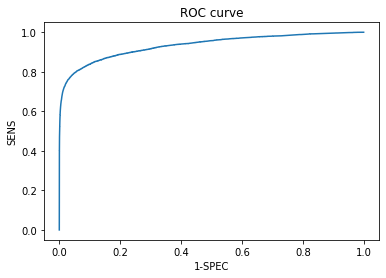

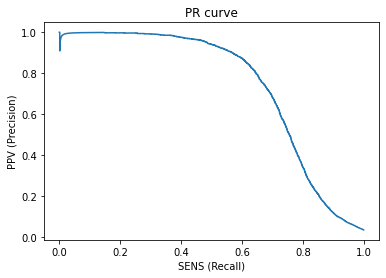

In [10]:
eva.evaluate("XGboost")

## Grid Search

In [12]:
import gc
import csv
gc.enable()
dtest = xgb.DMatrix(data=X_test, label=y_test)
xgb.set_config(verbosity=1)

fieldnames = ['max_depth', 'num_parallel_tree', 'TN', 'FP', 'FN', 'TP']
with open('grid_search_result.csv', 'a') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

for tree_depth in range(3,8):
    for num_tree in range(1,50):
#         temptrain = xgb.DMatrix(data=X_train, label=y_train)
#         if temptrain!=dtrain:
#             print("something")
#             break
#         else:
#             print("Good")
        if num_tree % 9 != 0:
            continue
        dtrain = xgb.DMatrix(data=X_train, label=y_train)
        booster = xgb.train({
            'objective': 'binary:logistic', 
            'eval_metric': ['auc', 'ams@0'],
            'max_depth': tree_depth,
            'num_parallel_tree': num_tree,
        }, dtrain=dtrain)
        y_pred_probs = booster.predict(dtest)
        y_pred_probs[y_pred_probs >= 0.5] = 1
        y_pred_probs[y_pred_probs < 0.5] = 0
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_probs).ravel()

        with open('grid_search_result.csv', 'a') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writerow({fieldnames[0]: tree_depth,
                             fieldnames[1]: num_tree,
                             fieldnames[2]: tn,
                             fieldnames[3]: fp,
                             fieldnames[4]: fn,
                             fieldnames[5]: tp})

        del booster
        del dtrain
        


KeyboardInterrupt: 

In [19]:
type(temptrain)

xgboost.core.DMatrix

In [25]:
temptrain.get_base_margin()

array([], dtype=float32)